# Classification Task

For this project's classification task, I chose the 'Hotel Booking Demand' dataset from Kaggle. The objective is to predict whether or not a hotel reservation ends up getting cancelled or not.


Source: https://www.kaggle.com/jessemostipak/hotel-booking-demand

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import pycats
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

## Data setup

#### Step 1) Load data

In [2]:
original = pd.read_csv(r'hotel_bookings.csv')
hotel_df = original.copy()
hotel_df.shape

(119390, 32)

In [3]:
hotel_df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

#### Step 2) Insert required missing values

In [4]:
hotel_df.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [5]:
print("Total number of missing values: ", original.isna().sum().sum())

Total number of missing values:  129425


We can see that there are currently 129,425 missing values. However, to meet the requirement of having 5% missing values (191,024), we still need to replace some (61,599 observations) values with missing values.

Before we can do implement a method to convert a certain percentage of random values to NaN, we have to replace the current NaN values with another value besides NaN, so that the method interprets them as numbers

In [6]:
random.seed(0)
hotel_df = hotel_df.mask(np.random.random(hotel_df.shape) <= 0.0168)

# 0.016124 is the proportion of missing values we still need to generate, 
    # so setting the maximum to be a little greater proportion than that

In [7]:
    # view new number of missing values in each column
hotel_df.isna().sum()

hotel                               2009
is_canceled                         2088
lead_time                           2088
arrival_date_year                   1982
arrival_date_month                  1976
arrival_date_week_number            2059
arrival_date_day_of_month           2018
stays_in_weekend_nights             1968
stays_in_week_nights                2019
adults                              2004
children                            1945
babies                              2007
meal                                1939
country                             2456
market_segment                      2007
distribution_channel                2060
is_repeated_guest                   2079
previous_cancellations              2072
previous_bookings_not_canceled      1958
reserved_room_type                  1915
assigned_room_type                  2015
booking_changes                     2051
deposit_type                        2033
agent                              18004
company         

In [8]:
print('New total number of missing values: ', (hotel_df.isna().sum().sum()))
#print('Train score: {:.4f}'.format(knn.score(X_train, y_train)))

New total number of missing values:  191509


In [9]:
print("Percentage of missing values in entire dataset: {:.4f} %".format(((hotel_df.isna().sum().sum()) / (119390*32))*100))

Percentage of missing values in entire dataset: 5.0127 %


## Data Preprocessing

#### Step 1) Handle outliers

Let's view all the numeric columns to see if there might be any outliers.

In [10]:
hotel_df.describe().round(2)

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,117302.00,117302.00,117408.00,117331.00,117372.00,117422.00,117371.00,117386.00,117445.0,117383.00,117311.00,117318.00,117432.00,117339.00,101386.00,6685.00,117371.00,117351.00,117400.00,117295.00
mean,0.37,104.04,2016.16,27.17,15.80,0.93,2.50,1.86,0.1,0.01,0.03,0.09,0.14,0.22,86.69,189.26,2.32,101.84,0.06,0.57
std,0.48,106.87,0.71,13.60,8.78,1.00,1.91,0.58,0.4,0.10,0.18,0.85,1.49,0.65,110.75,131.68,17.62,50.57,0.24,0.79
min,0.00,0.00,2015.00,1.00,1.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,1.00,6.00,0.00,-6.38,0.00,0.00
25%,0.00,18.00,2016.00,16.00,8.00,0.00,1.00,2.00,0.0,0.00,0.00,0.00,0.00,0.00,9.00,62.00,0.00,69.30,0.00,0.00
50%,0.00,69.00,2016.00,28.00,16.00,1.00,2.00,2.00,0.0,0.00,0.00,0.00,0.00,0.00,14.00,178.00,0.00,94.59,0.00,0.00
75%,1.00,160.00,2017.00,38.00,23.00,2.00,3.00,2.00,0.0,0.00,0.00,0.00,0.00,0.00,229.00,270.00,0.00,126.00,0.00,1.00
max,1.00,737.00,2017.00,53.00,31.00,19.00,50.00,55.00,10.0,10.00,1.00,26.00,72.00,21.00,535.00,543.00,391.00,5400.00,8.00,5.00


The only column with potential outliers is 'adr' (average daily rate). The maximum for this column is $5400. It is likely the case that there is an extra zero in this value. However, since we don't have information on prices at this hotel, it's impossible to confirm. Since it is not a good idea to manipulate the data provided to us, we will instead simply drop this observation.

The minimum value for the 'adr' column is -6.38, which also does not seem accurate. We will also drop this observation

In [11]:
hotel_df = hotel_df[hotel_df['adr'] != 5400]
hotel_df = hotel_df[hotel_df['adr'] != -6.38]
hotel_df.shape

(119388, 32)

What's also concerning is that there are several rows where 'adr' equals zero.

In [12]:
hotel_df[hotel_df['adr'] == 0 ]['adr'].count()

1923

Without more information, it's hard to interpret what an average daily rate of zero actually means. It's unlikely that the hotel lets guests stay for free. The observations could represent missing values, but we can't confirm. To be safe, we will drop these observations as well, which amounted to ~1.6% of the entire data set.

In [13]:
hotel_df = hotel_df[hotel_df['adr'] != 0]
hotel_df.shape

(117465, 32)

#### Step 2) Drop columns with high proportion of missing values

Since the 'company' column has a high proportion of missing values, we will drop it. We will also drop 'agent' because that column serves as an identifying column for the agent that made the sale. While it would be interesting from an HR perspective to see if some agents have more cancellations than others, that's not the purpose of this project. In addition, adding a dummy for each agent would amount to a dataset with too many columns. Hence, we will also drop this column

In [14]:
hotel_df.drop(['company', 'agent'], axis=1, inplace=True)
hotel_df.shape

(117465, 30)

#### Step 3) Drop leaked column

'reservation_status' is a leaked column, as it is a reflection of the 'is_canceled' column, which is what we are trying to predict. In addition, if we are dropping 'reservatinon_status,' then there is also no point in keeping 'reservation_status_date.'

In [15]:
hotel_df.drop(['reservation_status', 'reservation_status_date'], axis=1, inplace=True)
hotel_df.shape

(117465, 28)

#### Step 4) Drop unnecessary columns

1) 'arrival_date_year' is important for understanding trends. But if our ultimate goal is to create a business strategy, knowing the trends won't necessarily be helpful. Let's remove.

2) 'arrival_date_week_number' is already captured with month and day of month. In addition, keeping a column with 52 different categories will likely simply add to the high-dimensionality of our data. Let's drop.

3) 'arrival_date_day_of_month' has 31 different values. If we one-hot encode all of them, we will significantly increase the dimensionality of our data set. For business purposes, we are likely more interested in the month, because that will guide strategic decisions.

4) 'market_segment' and 'distribution_channel' are very similar in values. Let's drop 'market_segment,' which has more categories than 'distribution_channel.'

5) 'assigned_room_type' is similar to 'reserved_room_type.' The former likely has more influence than the latter on whether or not a booking is cancelled (assuming the customer finds out beforehand what room type they have been assigned). So let's drop 'reserved_room_type.'

6 & 7) 'required_car_parking_spaces' and 'total_of_special_requests' seem a little unnecessary as a predictor variable. There are several other variables that are likely much more influential than these. Let's drop.

In [16]:
hotel_df.drop(
    ['arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'market_segment', 'reserved_room_type', 'required_car_parking_spaces', 'total_of_special_requests'], 
    axis=1, inplace=True)
hotel_df.shape

(117465, 21)

#### Step 5) Missing values in numerical columns

##### A) 'is_canceled'

A missing value in the 'is_canceled' column renders the entire observation row meaningless, since that is the column value we are trying to predict. So, we will drop those rows.

In [17]:
hotel_df.dropna(subset=['is_canceled'], inplace=True)
hotel_df.reset_index(drop=True, inplace=True)
hotel_df

,hotel,is_canceled,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,...,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr
0,Resort Hotel,0.0,7.0,July,0.0,1.0,1.0,0.0,0.0,BB,...,Direct,0.0,0.0,0.0,C,0.0,No Deposit,0.0,Transient,75.00
1,Resort Hotel,0.0,13.0,July,0.0,1.0,1.0,0.0,0.0,BB,...,Corporate,0.0,0.0,0.0,A,0.0,No Deposit,0.0,Transient,75.00
2,Resort Hotel,0.0,14.0,July,0.0,2.0,2.0,0.0,0.0,BB,...,TA/TO,0.0,0.0,0.0,A,0.0,No Deposit,0.0,Transient,98.00
3,Resort Hotel,0.0,14.0,July,0.0,2.0,2.0,0.0,0.0,BB,...,TA/TO,0.0,0.0,0.0,A,0.0,No Deposit,0.0,Transient,98.00
4,Resort Hotel,0.0,0.0,July,0.0,2.0,2.0,0.0,0.0,BB,...,NaN,0.0,0.0,0.0,C,0.0,No Deposit,0.0,Transient,107.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115405,City Hotel,0.0,21.0,August,2.0,5.0,2.0,0.0,0.0,BB,...,TA/TO,0.0,0.0,0.0,A,0.0,No Deposit,0.0,Transient,96.14
115406,City Hotel,0.0,23.0,August,2.0,5.0,2.0,0.0,0.0,BB,...,TA/TO,0.0,0.0,0.0,A,0.0,No Deposit,0.0,Transient,96.14
115407,City Hotel,0.0,102.0,August,2.0,5.0,3.0,0.0,0.0,BB,...,TA/TO,0.0,0.0,0.0,E,0.0,No Deposit,0.0,Transient,225.43
115408,City Hotel,0.0,34.0,August,2.0,5.0,2.0,0.0,0.0,BB,...,TA/TO,0.0,0.0,0.0,D,0.0,No Deposit,0.0,Transient,157.71


##### B) Numerical column missing values

For all the missing values in the numerical columns, we will impute the median of the column. However, we will calculate separate medians for the canceled vs. not canceled reservations. We are using median (versus mean) because the mean is easily skewed by extreme outliers.

In [18]:
hotel_df['lead_time'] = hotel_df['lead_time'].fillna(hotel_df.groupby('is_canceled')['lead_time'].transform('median'))

hotel_df['stays_in_weekend_nights'] = hotel_df['stays_in_weekend_nights'].fillna(hotel_df.groupby('is_canceled')['stays_in_weekend_nights'].transform('median'))

hotel_df['stays_in_week_nights'] = hotel_df['stays_in_week_nights'].fillna(hotel_df.groupby('is_canceled')['stays_in_week_nights'].transform('median'))

hotel_df['adults'] = hotel_df['adults'].fillna(hotel_df.groupby('is_canceled')['adults'].transform('median'))

hotel_df['children'] = hotel_df['children'].fillna(hotel_df.groupby('is_canceled')['children'].transform('median'))

hotel_df['babies'] = hotel_df['babies'].fillna(hotel_df.groupby('is_canceled')['babies'].transform('median'))

hotel_df['is_repeated_guest'] = hotel_df['is_repeated_guest'].fillna(hotel_df.groupby('is_canceled')['is_repeated_guest'].transform('median'))

hotel_df['previous_cancellations'] = hotel_df['previous_cancellations'].fillna(hotel_df.groupby('is_canceled')['previous_cancellations'].transform('median'))

hotel_df['previous_bookings_not_canceled'] = hotel_df['previous_bookings_not_canceled'].fillna(hotel_df.groupby('is_canceled')['previous_bookings_not_canceled'].transform('median'))

hotel_df['booking_changes'] = hotel_df['booking_changes'].fillna(hotel_df.groupby('is_canceled')['booking_changes'].transform('median'))

hotel_df['days_in_waiting_list'] = hotel_df['days_in_waiting_list'].fillna(hotel_df.groupby('is_canceled')['days_in_waiting_list'].transform('median'))

hotel_df['adr'] = hotel_df['adr'].fillna(hotel_df.groupby('is_canceled')['adr'].transform('median'))


##### C) Categorical column missing values

For categorical columns, we will simply impute the most common class, without distinguishing by the value for the is_canceled column. The value differences are likely minor, and the main focus of this project is using machine learning algorithms.

In [19]:
hotel_df = hotel_df.apply(lambda x: x.fillna(x.value_counts().index[0]))
hotel_df.isna().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_month                0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
dtype: int64

#### Step 6) Convert column data types

In [20]:
    # convert categorical variables
# have to convert arrival_date_year to 'int64' first to get rid of decimal place
hotel_df = hotel_df.astype(
    {'hotel' : 'category',
    'is_canceled' : 'uint8',
    'lead_time' : 'int64',
    'arrival_date_month' : 'category',
    'stays_in_weekend_nights' : 'int64',
    'stays_in_week_nights' : 'int64',
    'adults' : 'int64', 'children' : 'int64', 'babies' : 'int64',
    'meal' : 'category', 
    'country' : 'category',
    'distribution_channel' : 'category', 
    'is_repeated_guest' : 'uint8',
    'previous_cancellations' : 'int64', 
    'previous_bookings_not_canceled' : 'int64',
    'assigned_room_type' : 'category', 
    'booking_changes' : 'int64', 
    'deposit_type' : 'category',
    'days_in_waiting_list' : 'int64', 
    'customer_type' : 'category', 
    'adr' : 'int64'
})

#hotel_df.info()


#### Step 7) Collapse 'country' column

We currently have 176 unique values in the 'country' column. Obviously one-hot encoding would lead to more columns than would be ideal. Increasing the number of columns in a dataset leads to a sparse dataset, which isn't ideal for many machine learning algorithms. So, we are collapsing this categorical column. We are doing this by grouping all countries that appear less than 10,000 times in this dataset.

In [21]:
    # dataframe of all unique countrues & how often they appear
unique_countries = pd.DataFrame(hotel_df['country'].value_counts()).reset_index()
unique_countries

,index,country
0,PRT,47847
1,GBR,11673
2,FRA,10018
3,ESP,8201
4,DEU,7002
...,...,...
172,NAM,1
173,NCL,1
174,DMA,1
175,NIC,1


In [22]:
    # dataframe of countries that appear less than 9,000 times
    # this will result in 4 groups, which is manageable for a model
group_countries = unique_countries[unique_countries['country'] <= 9000]

    # list of countries from above dataframe
country_list = group_countries['index'].to_list()

    # dictionary of those countries
group1 = {'Other' : country_list}

In [23]:
    # collapsing those countries
hotel_df['country'] = pycats.cat_collapse(hotel_df['country'], group1)
hotel_df['country'].nunique()

4

#### Step 8) Combine 'children' and 'babies'

In [24]:
hotel_df['under_18'] = hotel_df['children'] + hotel_df['babies']

    #delete 'children' & 'babies' column since it's already captured
hotel_df.drop(['children', 'babies'], axis=1, inplace=True)

## Exploratory Visualization

Is 'deposit_type' potentially an important predictor variable in determining whether a reservation is cancelled?

In [25]:
    # step 1: generate granular counts
table1 = hotel_df[['deposit_type', 'is_canceled']]
table1a = table1.groupby(['deposit_type', 'is_canceled']).size().rename('Granular Count').to_frame()
table1a

    # step 2: generate counts by deposit type
table1b = hotel_df[['deposit_type', 'is_canceled']]
table1b = table1b.groupby('deposit_type').count()
table1b.rename(columns={'is_canceled' : 'Count by Deposit Type'}, inplace=True)

    # step 3: join dataframes & calculate percentages
table1c = table1a.join(table1b, on='deposit_type')
table1c['Percentage'] = (table1c['Granular Count'] / table1c['Count by Deposit Type']) * 100
table1c

    # step 4: cut down to what I need
plot1 = table1c.copy()
plot1.reset_index(inplace=True)
plot1 = plot1[plot1['is_canceled'] == 1]
plot1.reset_index(inplace=True)
plot1 = plot1[['deposit_type', 'Count by Deposit Type', 'Percentage']]
plot1

,deposit_type,Count by Deposit Type,Percentage
0,No Deposit,101172,28.886451
1,Non Refund,14080,99.346591
2,Refundable,158,21.518987


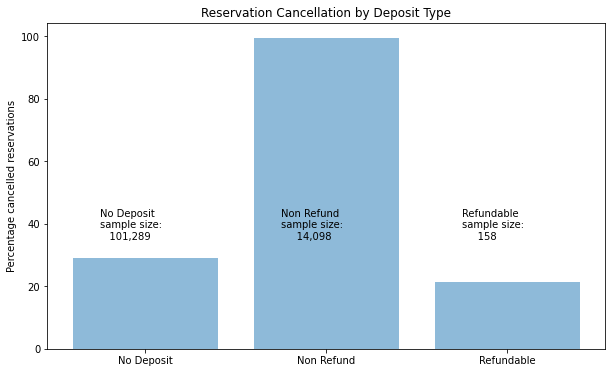

In [26]:
    # step 5: plot
objects = ('No Deposit', 'Non Refund', 'Refundable')
y_pos = np.arange(len(objects))
performance = [28.89, 99.37, 21.52]

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(y_pos, performance, alpha=0.5)
#plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Percentage cancelled reservations')
plt.title('Reservation Cancellation by Deposit Type')

ax.text(-0.25, 35, 'No Deposit\nsample size:\n   101,289')
ax.text(0.75, 35, 'Non Refund\nsample size:\n     14,098')
ax.text(1.75, 35, 'Refundable\nsample size:\n     158')

plt.show()

Clearly it looks like a deposit type of Non-Refundable is highly associated with a reservation cancellation. Nearly all non-refundable reservations were cancelled. This is counterintuitive, as you would expect non-refundable reservations to be less likely to be cancelled.

## Evaluation Metric Decision

In order to decide on a good evaluation metric, we need to decide if we are more interested in correctly predicting a case of a cancelled booking vs. not cancelled booking.

Let's first see what proportion of the target variable is cancelled vs. not cancelled.

In [27]:
hotel_df['is_canceled'].value_counts()
percent_cancelled = ( (hotel_df[hotel_df['is_canceled'] == 1].count()['is_canceled']) / hotel_df.shape[0] * 100)
print("Percentage of cancelled reservations: {:.4f} %".format(percent_cancelled))

Percentage of cancelled reservations: 37.4725 %


We can see that we have an imbalanced data set - only about 37% of observations have an 'is_canceled' value of 1, which means the booking did get cancelled. Since the project objective is to predict a cancellation, we want a model that predicts the positive values better than a baseline model. In other words, we are interested in precision and recall (also known as sensitivity). 

Precision answers the question: what percentage of selected observations are relevant? Its calculation is: true positive/(true positive + false positive). The higher the precision, the lower the number of false *positives* in the model. Recall (or sensitivity), on the other hand, answers the question: what percentage of relevant observations are selected? The higher the recall rate, the lower the number of false *negatives* in the model.

Obviously, we want to minimize the both the number of false positives and false negatives in our model. But let's think about which carries a greater a cost to the hotel. From a business perspective, the cost of a false positive is none to minimal. For predicted cancellations, a hotel staff member can call 24 hours in advance to confirm the reservation. If the guest decides to cancel, the hotel now has a vacancy that can go to another customer. And if the guest confirms the reservation, we're good to go. In short, for false positives, nothing is lost except the one to two minutes it takes to make the call. 

However, the consequence of a false negative is that the individual won't receive a confirmation call 24 hours in advance. The cost to the hotel is the lost revenue. If the hotel had known about this potential cancellation beforehand, they could have called the customer beforehand to prevent a situation where the cancellation is made too late for the room to go to another customer. So, the *cost of a false negative is more significant than that of a false positive.*

Since we care more about false negatives, we are more concerned with recall than we are with precision. Hence, the chosen evaluation metric is recall. Our goal is to produce a model with a __high recall__ rate.

## Machine Learning Algorithms

### Model 1: KNN Classification

In [28]:
from sklearn.neighbors import KNeighborsClassifier

In [29]:
hotel_knn = hotel_df.copy()

In [30]:
    # one hot encode the categorical variables
hotel_knn = pd.get_dummies(hotel_knn, columns = ['hotel'], prefix='hotel')
hotel_knn = pd.get_dummies(hotel_knn, columns = ['arrival_date_month'], prefix='month')
hotel_knn = pd.get_dummies(hotel_knn, columns = ['meal'], prefix='meal')
hotel_knn = pd.get_dummies(hotel_knn, columns = ['country'], prefix='country')
hotel_knn = pd.get_dummies(hotel_knn, columns = ['distribution_channel'], prefix='distr')
hotel_knn = pd.get_dummies(hotel_knn, columns = ['assigned_room_type'], prefix='room')
hotel_knn = pd.get_dummies(hotel_knn, columns = ['deposit_type'], prefix='deposit')
hotel_knn = pd.get_dummies(hotel_knn, columns = ['customer_type'], prefix='cust')
#hotel_knn.info()

Column rearrangement

In [31]:
hotel_knn.insert(5, 'under_18', hotel_knn.pop('under_18'))
hotel_knn.insert(11, 'is_repeated_guest', hotel_knn.pop('is_repeated_guest'))
#hotel_knn.info()

Need to take random sample, as the current data set is too large to run on a normal computer. We also make sure that the proportion of cancelled reservations is similar to the proportion observed in the original data set, which was ~37%.

In [32]:
hotel_knn_sample = hotel_knn.sample(n=10000, random_state=321).reset_index(drop=True)
#hotel_knn_sample = hotel_knn.sample(n=10000, weights='is_canceled', random_state=0).reset_index(drop=True)
hotel_knn_sample['is_canceled'].value_counts()

0    6239
1    3761
Name: is_canceled, dtype: int64

Split into predictor vs. target variables

In [33]:
X = hotel_knn_sample.drop('is_canceled', axis=1)
y = hotel_knn_sample['is_canceled']
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 57 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   lead_time                       10000 non-null  int64
 1   stays_in_weekend_nights         10000 non-null  int64
 2   stays_in_week_nights            10000 non-null  int64
 3   adults                          10000 non-null  int64
 4   under_18                        10000 non-null  int64
 5   previous_cancellations          10000 non-null  int64
 6   previous_bookings_not_canceled  10000 non-null  int64
 7   booking_changes                 10000 non-null  int64
 8   days_in_waiting_list            10000 non-null  int64
 9   adr                             10000 non-null  int64
 10  is_repeated_guest               10000 non-null  uint8
 11  hotel_City Hotel                10000 non-null  uint8
 12  hotel_Resort Hotel              10000 non-null  uint8
 13  mo

Train-test split. Setting 'stratify' parameter to target variable so split is proportional. We have an imbalanced data set, so this is important.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 0, test_size = 0.2)

Scale the numerical columns (not the one-hot encoded values)

In [35]:
    # Standard Scaler is usually preferred b/c helps you account for outliers & keeps dispersion
scaler = StandardScaler()

    # fit_transform for train data set, but just the numerical columns, not one-hot encoded columns
X_train.iloc[ : , 0:10] = scaler.fit_transform(X_train.iloc[ : , 0:10])
X_test.iloc[ : , 0:10] = scaler.transform(X_test.iloc[ : , 0:10])

Trying to visually get a range of the ideal number of neighbors.

In [36]:
train_score_array = []
test_score_array = []

for k in range(1,21):
    knn = KNeighborsClassifier(k)
    knn.fit(X_train, y_train)
    train_score_array.append(knn.score(X_train, y_train))
    test_score_array.append(knn.score(X_test, y_test))

Text(0, 0.5, 'MSE')

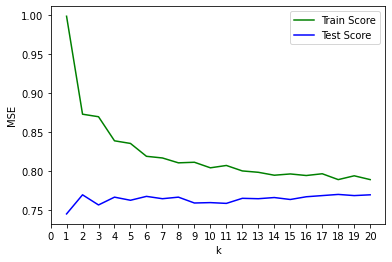

In [37]:
x_axis = range(1,21,1)
plt.plot(x_axis, train_score_array, c = 'g', label = 'Train Score')
plt.plot(x_axis, test_score_array, c = 'b', label = 'Test Score')
plt.legend()
plt.xticks(np.arange(0,21, step=1))
plt.xlabel('k')
plt.ylabel('MSE')

Now we will do a GridSearch to find the true ideal number of neighbors.

In [38]:
    # let's define the n_neighbors we want the grid search to search through.
    # looks like the n_neighbors that will minimize over & underfitting is somewhere between 14 & 21
knn_grid_params = {
    'n_neighbors': np.arange(14,21,1)
}

In [39]:
    # want the best parameter to be chosen based on recall score
grid_knn = GridSearchCV(
    KNeighborsClassifier(),
    knn_grid_params, 
   # scoring='recall',
    return_train_score=True,
   # verbose = 1,
    cv = 5,
    n_jobs = -1
)

In [40]:
    # fit to train model
grid_knn.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': array([14, 15, 16, 17, 18, 19, 20])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [41]:
grid_knn.best_params_

{'n_neighbors': 20}

##### KNN Model Evaluation

In [42]:
   # creating y_pred for use with model evaluation calculations
y_pred = grid_knn.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1140,  108],
       [ 352,  400]], dtype=int64)

In [43]:
print('Train score: {:.4f}'.format(grid_knn.score(X_train, y_train)))
print('Test score: {:.4f}'.format(grid_knn.score(X_test, y_test)))

print("Precision score: {:.4f}".format(precision_score(y_test, y_pred)))
print("Recall score: {:.4f}".format(recall_score(y_test, y_pred)))
print("F1 score: {:.4f}".format(f1_score(y_test, y_pred)))

Train score: 0.7895
Test score: 0.7700
Precision score: 0.7874
Recall score: 0.5319
F1 score: 0.6349


In summary, even though KNN gives us healthy train & test scores, the recall score isn't ideal at 54%. Let's look at other models.

### Model 2: Logistic Regression

In [44]:
from sklearn.linear_model import LogisticRegression

In [45]:
    # hotel_knn data set is similar to what we need for running log reg, so we can continue using same X & y's
hotel_logreg = hotel_knn.copy()    

In [46]:
X = hotel_logreg.drop('is_canceled', axis=1)
y = hotel_logreg['is_canceled']
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115410 entries, 0 to 115409
Data columns (total 57 columns):
 #   Column                          Non-Null Count   Dtype
---  ------                          --------------   -----
 0   lead_time                       115410 non-null  int64
 1   stays_in_weekend_nights         115410 non-null  int64
 2   stays_in_week_nights            115410 non-null  int64
 3   adults                          115410 non-null  int64
 4   under_18                        115410 non-null  int64
 5   previous_cancellations          115410 non-null  int64
 6   previous_bookings_not_canceled  115410 non-null  int64
 7   booking_changes                 115410 non-null  int64
 8   days_in_waiting_list            115410 non-null  int64
 9   adr                             115410 non-null  int64
 10  is_repeated_guest               115410 non-null  uint8
 11  hotel_City Hotel                115410 non-null  uint8
 12  hotel_Resort Hotel              115410 non-n

Train-test split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 0, test_size = 0.2)

Logistic regression is sensitive to scaling, so must scale.

In [48]:
    # Standard Scaler is usually preferred b/c helps you account for outliers & keeps dispersion
scaler = StandardScaler()

    # fit_transform for train data set, but just the numerical columns, not one-hot encoded columns
X_train.iloc[ : , 0:10] = scaler.fit_transform(X_train.iloc[ : , 0:10])
X_test.iloc[ : , 0:10] = scaler.transform(X_test.iloc[ : , 0:10])

In [49]:
    # these are the values of 'C' we want to gridsearch through
logreg_grid_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

In [50]:
    # want the best parameter to be chosen based on recall score
grid_logreg = GridSearchCV(
    LogisticRegression(random_state=321),
    logreg_grid_params, 
   # scoring='recall',
    return_train_score=True,
   # verbose = 1,
    cv = 5,
    n_jobs = -1
)

In [51]:
    # fit to train model
grid_logreg.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=321, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [52]:
grid_logreg.best_params_

{'C': 100}

##### Logistic Regression Model Evaluation

In [53]:
   # creating y_pred for use with model evaluation calculations
y_pred_lr = grid_logreg.predict(X_test)
confusion_matrix(y_test, y_pred_lr)

array([[13319,  1114],
       [ 4011,  4638]], dtype=int64)

In [54]:
print('Train score: {:.4f}'.format(grid_logreg.score(X_train, y_train)))
print('Test score: {:.4f}'.format(grid_logreg.score(X_test, y_test)))

print("Precision score: {:.4f}".format(precision_score(y_test, y_pred_lr)))
print("Recall score: {:.4f}".format(recall_score(y_test, y_pred_lr)))
print("F1 score: {:.4f}".format(f1_score(y_test, y_pred_lr)))

Train score: 0.7788
Test score: 0.7780
Precision score: 0.8063
Recall score: 0.5362
F1 score: 0.6441


We achieve a very slightly higher recall score with logistic regression as compared to KNN.

### Model 3: Linear SVM

In [55]:
from sklearn.svm import LinearSVC

In [56]:
    # hotel_knn dataset is similar to what we need for running linear SVM, so we can continue using same X & y's
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 0, test_size = 0.2)

In [57]:
    # these are the values of 'C' we want to gridsearch through
linSVM_grid_params = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

In [58]:
    # want the best parameter to be chosen based on recall score
grid_linSVM = GridSearchCV(
    LinearSVC(penalty='l2', random_state=789,
        dual=False), # setting dual=False bc that's what's preferred when n_samples > n_features
    linSVM_grid_params, 
  #  scoring='recall',
    return_train_score=True,
   # verbose = 1,
    cv = 5,
    n_jobs = -1
)

In [59]:
    # fit to train model
grid_linSVM.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=False,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=789, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [60]:
grid_linSVM.best_params_

{'C': 100}

##### Linear SVM Model Evaluation

In [61]:
   # creating y_pred for use with model evaluation calculations
y_pred_linsvm = grid_linSVM.predict(X_test)
confusion_matrix(y_test, y_pred_linsvm)

array([[13453,   980],
       [ 4174,  4475]], dtype=int64)

In [62]:
print('Train score: {:.4f}'.format(grid_linSVM.score(X_train, y_train)))
print('Test score: {:.4f}'.format(grid_linSVM.score(X_test, y_test)))

print("Precision score: {:.4f}".format(precision_score(y_test, y_pred_linsvm)))
print("Recall score: {:.4f}".format(recall_score(y_test, y_pred_linsvm)))
print("F1 score: {:.4f}".format(f1_score(y_test, y_pred_linsvm)))

Train score: 0.7767
Test score: 0.7767
Precision score: 0.8203
Recall score: 0.5174
F1 score: 0.6346


Linear SVM performed worse than both KNN and Logistic Regression

### Model 4: Kernelized SVM (rbf, poly, linear)

#### 4a: SVM (kernel = 'rbf')

In [63]:
from sklearn.svm import SVC

SVM requires high computing power. Due to limited resources, we are forced to cut the sample size. Again, we make sure that the proportion of cancelled reservations in this sample is about the same as in the original dataset.

In [64]:
hotel_svm = hotel_knn.copy()
#hotel_svm.info()

In [65]:
hotel_svm_sample = hotel_svm.sample(n=1000, random_state=789).reset_index(drop=True)
hotel_svm_sample['is_canceled'].value_counts()

0    595
1    405
Name: is_canceled, dtype: int64

In [66]:
X = hotel_svm_sample.drop('is_canceled', axis=1)
y = hotel_svm_sample['is_canceled']
#X.info()

In [67]:
    # hotel_knn dataset is similar to what we need for running linear SVM, so we can continue using same X & y's
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 0, test_size = 0.2)

In [68]:
    # Standard Scaler is usually preferred b/c helps you account for outliers & keeps dispersion
scaler = StandardScaler()

    # fit_transform for train data set, but just the numerical columns, not one-hot encoded columns
X_train.iloc[ : , 0:10] = scaler.fit_transform(X_train.iloc[ : , 0:10])
X_test.iloc[ : , 0:10] = scaler.transform(X_test.iloc[ : , 0:10])

In [69]:
    # these are the values of 'C' we want to gridsearch through
SVM1_grid_params = {
    'gamma' : [0.001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

In [70]:
    # want the best parameter to be chosen based on recall score
grid_SVM1 = GridSearchCV(
    SVC(kernel='rbf', random_state=123),
    SVM1_grid_params, 
   # scoring='recall',
    return_train_score=True,
   # verbose = 1,
    cv = 5,
    n_jobs = -1
)

In [71]:
    # fit to train model
grid_SVM1.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=123, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': [0.001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [72]:
grid_SVM1.best_params_

{'C': 1, 'gamma': 0.1}

##### SVM (kernel = 'rbf') Model Evaluation

In [73]:
   # creating y_pred for use with model evaluation calculations
y_pred_svm1 = grid_SVM1.predict(X_test)
confusion_matrix(y_test, y_pred_svm1)

array([[111,   8],
       [ 43,  38]], dtype=int64)

In [74]:
print('Train score: {:.4f}'.format(grid_SVM1.score(X_train, y_train)))
print('Test score: {:.4f}'.format(grid_SVM1.score(X_test, y_test)))

print("Precision score: {:.4f}".format(precision_score(y_test, y_pred_svm1)))
print("Recall score: {:.4f}".format(recall_score(y_test, y_pred_svm1)))
print("F1 score: {:.4f}".format(f1_score(y_test, y_pred_svm1)))

Train score: 0.8425
Test score: 0.7450
Precision score: 0.8261
Recall score: 0.4691
F1 score: 0.5984


Still a sub-par model, based on the recall score.

#### 4b: SVM (kernel = 'poly')

We can still use the same hotel_svm_sample from above.

In [75]:
    # these are the values of 'C' we want to gridsearch through
SVM2_grid_params = {
    'degree' : [2,3,4],
    'gamma' : [0.001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

In [76]:
    # want the best parameter to be chosen based on recall score
grid_SVM2 = GridSearchCV(
    SVC(kernel='poly', random_state=123),
    SVM2_grid_params, 
   # scoring='recall',
    return_train_score=True,
   # verbose = 1,
    cv = 5,
    n_jobs = -1
)

In [77]:
    # fit to train model
grid_SVM2.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='poly', max_iter=-1,
                           probability=False, random_state=123, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'degree': [2, 3, 4],
                         'gamma': [0.001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [78]:
grid_SVM2.best_params_

{'C': 0.001, 'degree': 3, 'gamma': 1}

##### SVM (kernel = 'poly') Model Evaluation

In [79]:
   # creating y_pred for use with model evaluation calculations
y_pred_svm2 = grid_SVM2.predict(X_test)
confusion_matrix(y_test, y_pred_svm2)

array([[108,  11],
       [ 36,  45]], dtype=int64)

In [80]:
print('Train score: {:.4f}'.format(grid_SVM2.score(X_train, y_train)))
print('Test score: {:.4f}'.format(grid_SVM2.score(X_test, y_test)))

print("Precision score: {:.4f}".format(precision_score(y_test, y_pred_svm2)))
print("Recall score: {:.4f}".format(recall_score(y_test, y_pred_svm2)))
print("F1 score: {:.4f}".format(f1_score(y_test, y_pred_svm2)))

Train score: 0.8888
Test score: 0.7650
Precision score: 0.8036
Recall score: 0.5556
F1 score: 0.6569


#### 4c: SVM (kernel = 'linear')

We can still use the same hotel_svm_sample from above.

In [81]:
    # these are the values of 'C' we want to gridsearch through
SVM3_grid_params = {
    'gamma' : [0.001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

In [82]:
    # want the best parameter to be chosen based on recall score
grid_SVM3 = GridSearchCV(
    SVC(kernel='linear', random_state=321),
    SVM3_grid_params, 
    scoring='recall',
    return_train_score=True,
   # verbose = 1,
    cv = 5,
    n_jobs = -1
)

In [83]:
    # fit to train model
grid_SVM3.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='linear', max_iter=-1,
                           probability=False, random_state=321, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': [0.001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='recall', verbose=0)

In [84]:
grid_SVM3.best_params_

{'C': 1000, 'gamma': 0.001}

##### SVM (kernel = 'linear') Model Evaluation

In [85]:
   # creating y_pred for use with model evaluation calculations
random_state=321321
y_pred_svm3 = grid_SVM3.predict(X_test)
confusion_matrix(y_test, y_pred_svm3)

array([[110,   9],
       [ 39,  42]], dtype=int64)

In [86]:
print('Train score: {:.4f}'.format(grid_SVM3.score(X_train, y_train)))
print('Test score: {:.4f}'.format(grid_SVM3.score(X_test, y_test)))

print("Precision score: {:.4f}".format(precision_score(y_test, y_pred_svm3)))
print("Recall score: {:.4f}".format(recall_score(y_test, y_pred_svm3)))
print("F1 score: {:.4f}".format(f1_score(y_test, y_pred_svm3)))

Train score: 0.5679
Test score: 0.5185
Precision score: 0.8235
Recall score: 0.5185
F1 score: 0.6364


Very high precision, but still low recall.

### Model 5: Decision Trees

In [87]:
from sklearn.tree import DecisionTreeClassifier

Decision trees are also unable to handle categorical data. However, scaling doesn't make a difference in decision trees, so we will not scale the data.

In [88]:
hotel_dtree = hotel_knn.copy()
hotel_dtree

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,under_18,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,...,room_I,room_K,room_L,deposit_No Deposit,deposit_Non Refund,deposit_Refundable,cust_Contract,cust_Group,cust_Transient,cust_Transient-Party
0,0,7,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,13,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,14,0,2,2,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,14,0,2,2,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,0,0,2,2,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115405,0,21,2,5,2,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
115406,0,23,2,5,2,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
115407,0,102,2,5,3,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
115408,0,34,2,5,2,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [89]:
X = hotel_dtree.drop('is_canceled', axis=1)
y = hotel_dtree['is_canceled']
y.value_counts()

0    72163
1    43247
Name: is_canceled, dtype: int64

Decision trees are not sensitive to scaling, so no need to scale.

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 0, test_size = 0.2)

In [91]:
    # these are the values of 'C' we want to gridsearch through
dtree_grid_params = {
    'max_depth': range(2,8),
    'min_samples_split': range(2,12,1),
    'max_leaf_nodes': range(2,10)
}

In [92]:
    # want the best parameter to be chosen based on recall score
grid_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=123),
    dtree_grid_params, 
   # scoring='recall',
    return_train_score=True,
   # verbose = 1,
    cv = 5,
    n_jobs = -1
)

In [93]:
grid_tree.fit(X_train, y_train)
grid_tree.best_params_

{'max_depth': 5, 'max_leaf_nodes': 9, 'min_samples_split': 2}

##### Decision Tree Model Evaluation

In [94]:
dtree = DecisionTreeClassifier(max_depth=5, max_leaf_nodes=9, min_samples_split=2, random_state=123)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=9,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

In [95]:
   # creating y_pred for use with model evaluation calculations
y_pred_dtree = dtree.predict(X_test)
confusion_matrix(y_test, y_pred_dtree)

array([[12787,  1646],
       [ 3661,  4988]], dtype=int64)

In [96]:
print('Train score: {:.4f}'.format(dtree.score(X_train, y_train)))
print('Test score: {:.4f}'.format(dtree.score(X_test, y_test)))

print("Precision score: {:.4f}".format(precision_score(y_test, y_pred_dtree)))
print("Recall score: {:.4f}".format(recall_score(y_test, y_pred_dtree)))
print("F1 score: {:.4f}".format(f1_score(y_test, y_pred_dtree)))

Train score: 0.7708
Test score: 0.7701
Precision score: 0.7519
Recall score: 0.5767
F1 score: 0.6528


Surprisingly, Decision Tree's performance is not significantly different than that of any of the other models

Visualizing feature importance

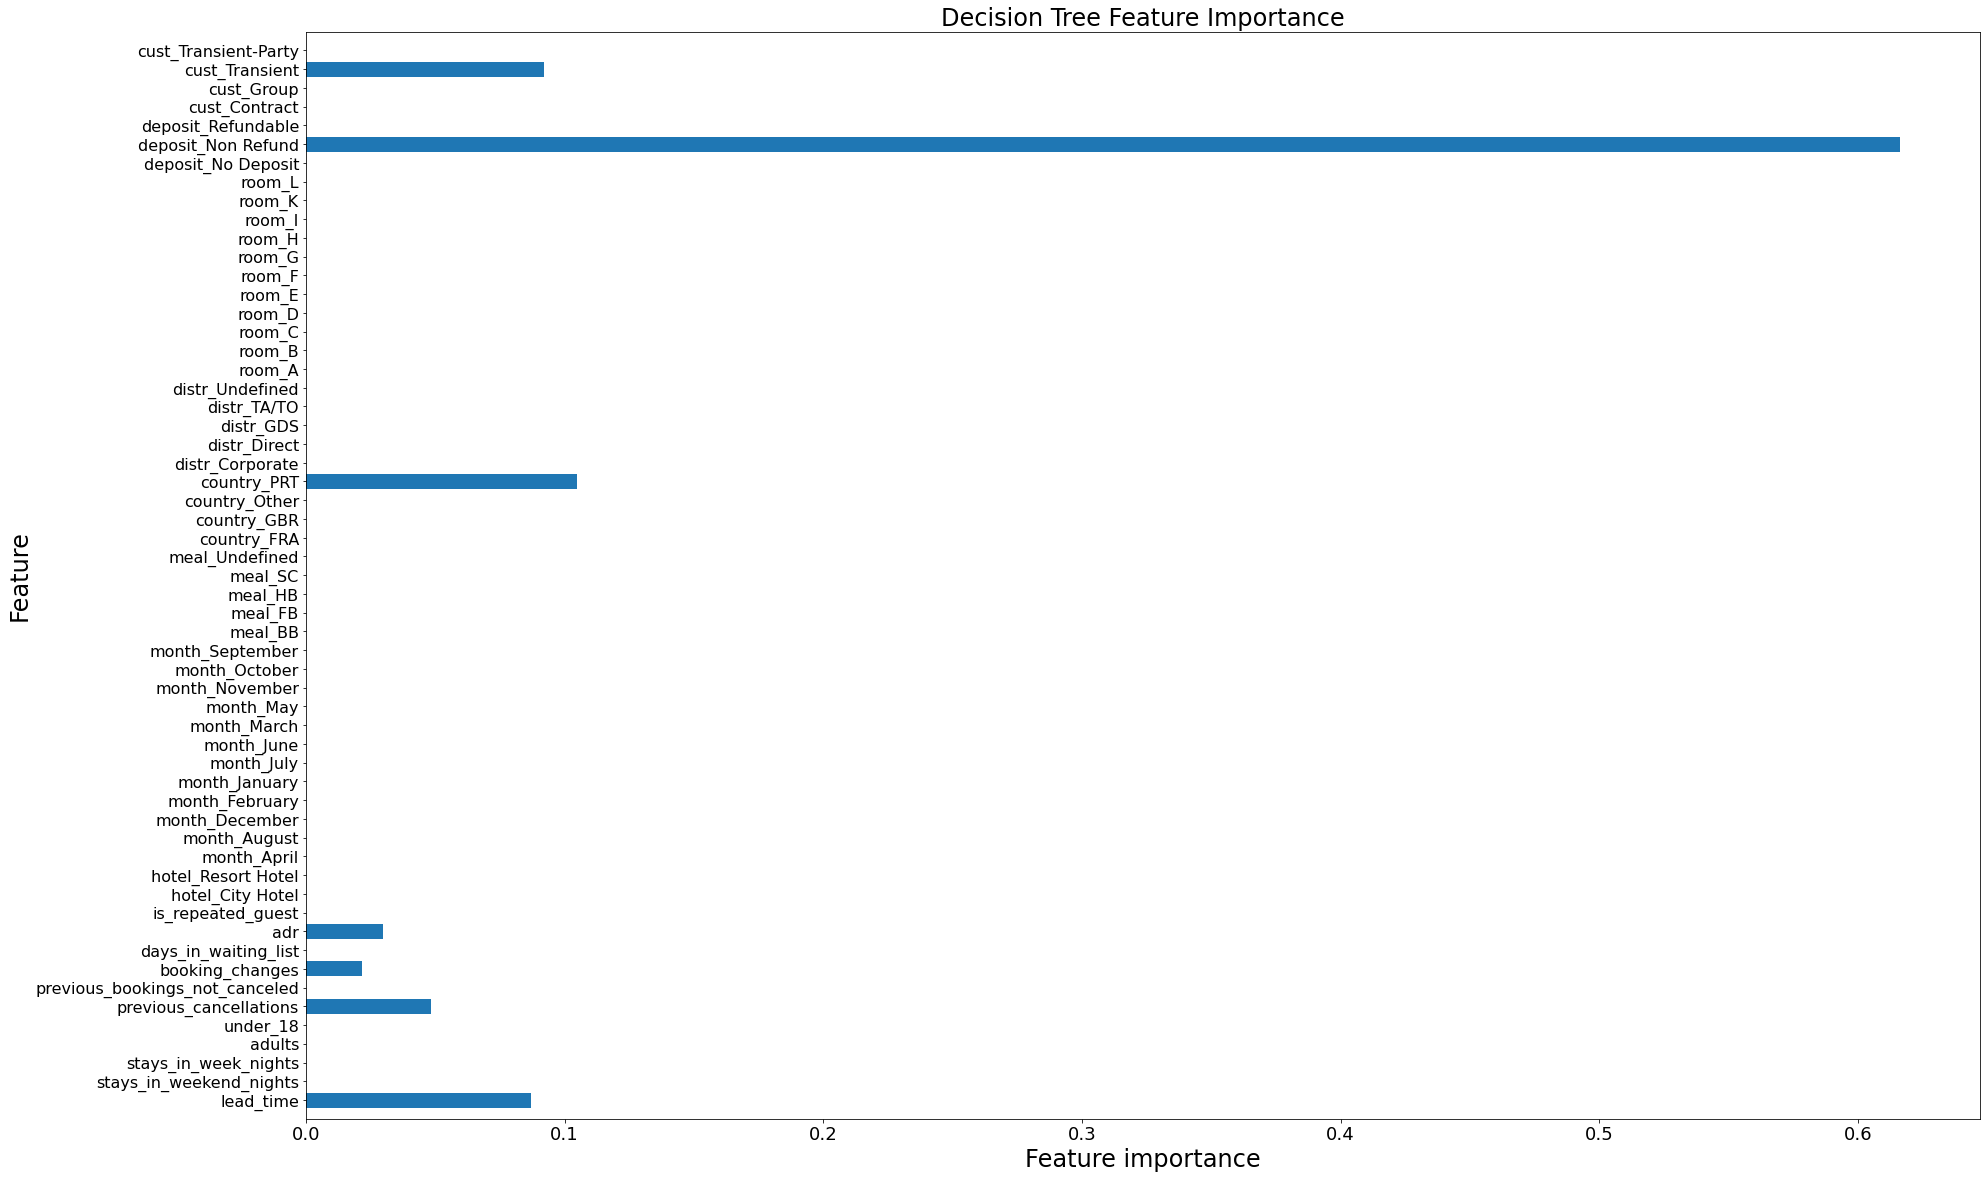

In [97]:
%matplotlib inline
def plot_feature_importances_cancer(model):
    fig, ax = plt.subplots(figsize=(30,20))
    n_features = X_train.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.title('Decision Tree Feature Importance', size=24)
    plt.yticks(np.arange(n_features), X_train.columns, size=16)
    plt.xticks(size=18)
    plt.xlabel("Feature importance", size=24)
    plt.ylabel("Feature", size=24)
    plt.ylim(-1, n_features)

plot_feature_importances_cancer(dtree)

Clearly, the most important feature in predicting whether a reservation gets cancelled is whether the deposit was non-refundable or not. This is counterintuitive, as you would expect the situation to be such that when deposits are non-refundable, there are fewer cancellations.

The fact that country_PRT (which means that the country of the reservation is Portugal) is an important feature is not surprising. The hotel is in Portugal, so people who live closer to the hotel are not traveling as far, and so the trip likely was not a big deal for them. Hence, they would be more likely to cancel. In addition, of all the 'country' categories, Portugal has the most observations. So the fact that it's important could be due to the fact that we have a greater sample size that fits the country=Portugal criteria.

Other important factors are intuitive: adr (average daily rate), previous_cancellations (whether this guest had cancelled reservations in the past), and lead_time (how far in advance the rservation was made).

### Model Summaries & Best Model Selection

|   | Model Name | Train Score | Test Score | Precision Score | Recall Score | F1 Score |
| - | ---------- | ----------- | ---------- | --------------- | ------------ | -------- |
| 1 |   KNN      |      0.7895 |      0.7700 |         0.7874 |       0.5319 |  0.6349  |
| 2 | Logistic Regression    | 0.7788 | 0.7780 |     0.8063   |    0.5362    |  0.6441  |
| 3 | Linear SVM  | 0.7767 | 0.7767 |   0.8203  | 0.5174 | 0.6346
| 4a |  SVM, kernel='rbf'   | 0.8425 | 0.7450 |   0.8261  | 0.4691 | 0.5984
| 4b |  SVM, kernel='poly'  | 0.8888 | 0.7650 |   0.8036  | 0.5556 | 0.6569
| 4c |  SVM, kernel='linear' | 0.5679 | 0.5185 |  0.8235  | 0.5185 | 0.6364
| 5 | Decision Tree  | 0.7708 | 0.7701 |  0.7519  | 0.5767 | 0.6528

Based on recall score, the Decision Tree model gives the best performance. However, most of the other models (except 4a), are not too far behind.

### Business Applications

As a further extension of this machine learning algorithm analysis, we wanted to think about how we can guide the hotel to apply our model to add value.

One suggestion we had was to have the hotel use our model to predict cancellations. Hotel employees can then call expected guests 48 hours before check-in time to confirm the reservation. That way, if the guest decides to cancel, the space becomes free for another potential guest.